<a href="https://colab.research.google.com/github/abyanahmadn/Dicoding-NLP-Model-TensorFlow/blob/main/Dicoding_P1_NLP_Model_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dicoding ML Intermediate Project 1**

**Title: Create NLP Model with TensorFlow**

**Identity:**
* Name: Abyan Ahmad Nurrasyid
* Email: abyanahmadn@gmail.com

**Dataset : "Indonesian Names and Its Gender"** \
> Sumber : Kaggle \
> Link Dataset : https://www.kaggle.com/dionisiusdh/indonesian-names

In [70]:
from google.colab import drive

# u/ dataframe
import pandas as pd

# u/ split data
from sklearn.model_selection import train_test_split

# u/ preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #u/ menggunakan padding
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# u/ visualisasi plot
import matplotlib.pyplot as plt

Mount ke drive

In [71]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read Dataset dari drive

In [72]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/2. Dicoding ML Menengah/indonesian-names.csv")
df.head()

,name,gender
0,hafizhan shidqi,m
1,gandhi wibowo,m
2,aldio mahendra purwandrarto,m
3,benny putra,m
4,vicky vernando dasta,m


In [73]:
df.tail()

,name,gender
1955,hadimah,f
1956,aprillia rahma wati,f
1957,muhamad khoirunisa. m,m
1958,sukandi,m
1959,eem,f


In [74]:
df['gender'].value_counts()

m    1094
f     866
Name: gender, dtype: int64

Pengecekan nilai kosong

In [75]:
# Mengecek nilai kosong / nan
# Jika true maka ada dan jika false maka tidak ada nilai kosong / nan
df.isnull().values.any()

False

# One-Hot-Encoding
Karena label berupa data kategorikal, maka perlu melakukan proses one-hot-encoding dan membuat dataframe baru.

In [77]:
gender = pd.get_dummies(df.gender) # proses one hot encoding
df_gender = pd.concat([df, gender], axis=1) # menggabung df lama dengan column hasil O-H-E mjd df baru (df_gender), axis = 1 artinya secara horizontal
df_gender = df_gender.drop(columns='gender') # menghapus column 'gender' karena sdh tdk dipakai
df_gender.tail()

,name,f,m
1955,hadimah,1,0
1956,aprillia rahma wati,1,0
1957,muhamad khoirunisa. m,0,1
1958,sukandi,0,1
1959,eem,1,0


Mengubah nama column 'f' dan 'm' mejadi 'female' dan 'male'

In [78]:
df_gender.rename(columns={df_gender.columns[1]:'female', df_gender.columns[2]:'male'}, inplace=True) # inplace=True -> ngereplace df (saving the df back to the same df variabl), inplace=False -> make a copy df
df_gender.tail()

,name,female,male
1955,hadimah,1,0
1956,aprillia rahma wati,1,0
1957,muhamad khoirunisa. m,0,1
1958,sukandi,0,1
1959,eem,1,0


Setelah itu kita akan menghitung jumlah kata yang terdapat pada kolom text dengan membuat fungsi sendiri. Fungsi penghitungan kata ini akan digunakan sebagai bentuk dari data. Hasil dari fungsi ini akan digunakan sebagai patokan dalam membuat input layer pada model.

In [79]:
from collections import Counter

def wordCount(name):
  count = Counter()
  for i in name.values():
    for word in i.split():
      count[word] += 1
  return count

name = df.name
counter = wordCount(name)

num_word = len(counter)
print(numword)

TypeError: ignored

# Mengubah ke tipe data numpy array
Agar dapat diproses oleh model, kita perlu mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values.

In [80]:
# Mengubah tipe data menjadi numpy array 
#text = df_gender['name'].astype(str) # mengubah mjd str
name = df_gender['name'].values
label = df_gender[['female', 'male',]].values

# Memisah Data Ke Beberapa Bagian

Lalu, bagi data untuk training dan data untuk testing.

In [81]:
name_train, name_test, label_train, label_test = train_test_split(name, 
                                                                  label, 
                                                                  test_size = 0.2) # Validation set sebesar 20% dari total dataset.

# Tokenizer, Sequences, Padding
Kemudian ubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, perlu mengonversi setiap sampel menjadi sequence.

Pada tokenisasi terdapat masalah apabila sebuah kata memiliki jumlah dan huruf yang sama seperti “karus” dan “rusak”. Mesin akan membeca kedua kata tersebut adalah sama, maka dari itu kita membutuhkan **Pengurutan (sequences)**.

**Pengurutan (sequences)** akan menampung setiap token yang ada ke dalam bentuk array. Dengan begitu masalah sebelumnya dapat terselesaikan.

Pada array yang dibuat dengan sequences memiliki panjang yang berbeda-beda dan membuat penginputan data akan menjadi sulit. Kita harus menyamakan panjang pada setiap sequences. Proses penyamaan panjang (resize) bisa disebut juga dengan **padding**.


In [82]:
# tokenizer = digunakan untuk mengubah setiap huruf pada setiap kata ke dalam angka tertentu seperti pada format ASCII.
tokenizer = Tokenizer(num_words=10000 , oov_token='-') # oov_token -> digunakan jika ada huruf yg tdk dapat ditokenisasi dg baik. Huruf akan diubah mjd karakter yang kita tentukan ('-').
tokenizer.fit_on_texts(name_train)
tokenizer.fit_on_texts(name_test)

# mengonversi ke sequence
sekuens_train = tokenizer.texts_to_sequences(name_train)
sekuens_test = tokenizer.texts_to_sequences(name_test)

# padding = membuat setiap kalimat pada teks memiliki panjang yang seragam
padded_train = pad_sequences(sekuens_train,
                             maxlen=10,
                             padding='post',
                             truncating='post') 
padded_test = pad_sequences(sekuens_test,
                            maxlen=10,
                            padding='post',
                            truncating='post')


# Modelling
Pemodelan Sequential dengan Embedding dan LSTM


In [83]:
model = Sequential([Embedding(input_dim=10000, # dimensi dari input sebesar nilai num_words pada objek tokenizer
                    output_dim=16, # dimensi embedding sebesar 16 
                    input_length=None), 
                    LSTM(64),
                    Dense(256, activation='relu'),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(32, activation='relu'),
                    Dropout(0.5),
                    Dense(2, activation='sigmoid') # hanya 2 kelas maka menggunakan fungsi sigmoid
                    ])

#model.summary()

# Callback
Penggunaan callback u/ accuracy dan val diatas 90%

In [84]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

# Training Model

Sebelum melakukan training, compile terlebih dahulu model yang sudah dirancang tadi.

In [85]:
Adam(learning_rate=0.00146, name='Adam')
# Adam(learning_rate= 0.0005, name='Adam')

model.compile(optimizer = 'Adam',
              loss = 'binary_crossentropy', # binary_crossentropy krn klasifikasi 2 kelas. Kalo 3 kelas atau lebih = categorical_crossentropy -> outputnya hasil O-H-E. sparse_categorical_crossentropy -> output integer (e.g: 1, 2, 3)
              metrics = ['accuracy'])

Pada saat training menggunakan fit(), masukan data teks yang telah di padding beserta labelnya.

In [86]:
num_epochs = 30
history = model.fit(padded_train, 
                    label_train, 
                    epochs=num_epochs, 
                    validation_data=(padded_test, label_test), 
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/30
49/49 - 3s - loss: 0.6898 - accuracy: 0.5568 - val_loss: 0.6905 - val_accuracy: 0.5357 - 3s/epoch - 57ms/step
Epoch 2/30
49/49 - 0s - loss: 0.6857 - accuracy: 0.5606 - val_loss: 0.6910 - val_accuracy: 0.5357 - 469ms/epoch - 10ms/step
Epoch 3/30
49/49 - 0s - loss: 0.6692 - accuracy: 0.5625 - val_loss: 0.5694 - val_accuracy: 0.6964 - 464ms/epoch - 9ms/step
Epoch 4/30
49/49 - 0s - loss: 0.3287 - accuracy: 0.8648 - val_loss: 0.5649 - val_accuracy: 0.7500 - 462ms/epoch - 9ms/step
Epoch 5/30
49/49 - 0s - loss: 0.1583 - accuracy: 0.9617 - val_loss: 0.8856 - val_accuracy: 0.7806 - 464ms/epoch - 9ms/step
Epoch 6/30
49/49 - 0s - loss: 0.0776 - accuracy: 0.9853 - val_loss: 1.1109 - val_accuracy: 0.7755 - 486ms/epoch - 10ms/step
Epoch 7/30
49/49 - 0s - loss: 0.0595 - accuracy: 0.9949 - val_loss: 1.2367 - val_accuracy: 0.7755 - 470ms/epoch - 10ms/step
Epoch 8/30
49/49 - 0s - loss: 0.0364 - accuracy: 0.9974 - val_loss: 1.4872 - val_accuracy: 0.7679 - 483ms/epoch - 10ms/step
Epoch 9/30
49/

# Visualize training results


Untuk evaluasi pelatihan model, kita akan menggunakan matplotlib untuk membuat grafik histori dari pelatihan sebelumnya.

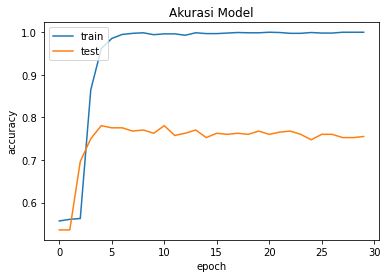

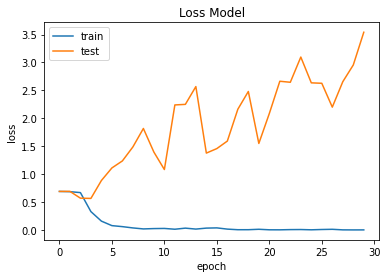

In [87]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()